In [1]:
#  !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# hate_yes_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_yes.csv')
# hate_no_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_no.csv')

# torch.set_default_tensor_type(torch.cuda.HalfTensor)

## **1. Datasets.**

In [1]:
import re
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForCausalLM
from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer, BertForMaskedLM, BertModel
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

/Users/sabrinasadieh/Code/ccs_aisf/ccs_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Models to run

1. `Elron/deberta-v3-large-hate` - encoder
2. `gpt2-large` - decoder +
3. `gpt2` - decoder + 
4. `ayushdh96/HateSpeech_Bert_Base_Uncased_Fine_Tuned` - encoder-decoder +
5. `google-bert/bert-base-uncased` - encoder-decoder + 
5. `openlm-research/open_llama_3b_v2`
6. `openlm-research/open_llama_13b`


In [58]:
ROOT = '/Users/sabrinasadieh/Code/ccs_aisf/'

real_vs_ideal_world_data = pd.read_csv(ROOT+'data/raw/real_vs_ideal_world.csv', index_col=0)
hate_data = pd.read_csv(ROOT+'data/raw/hate_vs_antagonist.csv', index_col=0)

real_vs_ideal_world_yes_data = pd.read_csv(ROOT+'data/yes_no/real_vs_ideal_world_yes.csv', index_col=0)
real_vs_ideal_world_no_data = pd.read_csv(ROOT+'data/yes_no/real_vs_ideal_world_no.csv', index_col=0)

hate_yes_data = pd.read_csv(ROOT+'data/yes_no/hate_vs_antagonist_yes.csv', index_col=0)
hate_no_data = pd.read_csv(ROOT+'data/yes_no/hate_vs_antagonist_no.csv', index_col=0)

In [32]:
hate_not_data = pd.read_csv(ROOT+'data/raw/hate_vs_antagonist_negation_balanced.csv')

hate_not_data_yes = hate_not_data.copy()
hate_not_data_yes['statement'] =  hate_not_data_yes['statement'].apply(lambda x: x+ 'Yes.')

hate_not_data_no = hate_not_data.copy()
hate_not_data_no['statement'] =  hate_not_data_no['statement'].apply(lambda x: x+ 'No.')

In [45]:
hate_not_data_yes_rnd_check = hate_not_data_yes.copy()
hate_not_data_no_rnd_check = hate_not_data_no.copy()

In [46]:
hate_not_data_yes_rnd_check['statement'] = hate_not_data_yes_rnd_check['statement'].apply(
                                    lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))
hate_not_data_no_rnd_check['statement'] = hate_not_data_no_rnd_check['statement'].apply(
                                        lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))

In [48]:
hate_not_data_yes_rnd_check['statement'].apply(lambda x: 'ttt' in x).sum(), hate_not_data_no_rnd_check['statement'].apply(lambda x: 'ttt' in x).sum()

(np.int64(257), np.int64(257))

## **2. Choose model.**

In [135]:
MODEL_NAME = "HateSpeech_Bert_Base_Uncased_Fine_Tuned_DEC"
MODEL_TYPE = 'encoder-decoder'
TOKEN_NUMBER = -1

USE_DEC = True

encoder_model_tokenizer = BertTokenizer.from_pretrained('ayushdh96/HateSpeech_Bert_Base_Uncased_Fine_Tuned')
encoder_model = EncoderDecoderModel.from_encoder_decoder_pretrained("ayushdh96/HateSpeech_Bert_Base_Uncased_Fine_Tuned", 
                                                                    "ayushdh96/HateSpeech_Bert_Base_Uncased_Fine_Tuned")

# encoder_model_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# encoder_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# encoder_model_tokenizer = AutoTokenizer.from_pretrained("Elron/deberta-v3-large-hate")
# encoder_model = AutoModelForMaskedLM.from_pretrained("Elron/deberta-v3-large-hate")

encoder_model.eval();

encoder_model_tokenizer.add_special_tokens({'pad_token': '[PAD]'})


Some weights of BertLMHeadModel were not initialized from the model checkpoint at ayushdh96/HateSpeech_Bert_Base_Uncased_Fine_Tuned and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossa

0

### **3. Get hidden states**

In [108]:
import sys
import os

sys.path.append(os.path.abspath(os.path.dirname('/Users/sabrinasadieh/Code/ccs_aisf/code/ccs.py')))

In [136]:
from extract import vectorize_df, extract_representation

X_pos = vectorize_df(hate_not_data_yes['statement'], # текст как столбец df
                                   encoder_model, # модель
                                   encoder_model_tokenizer, # токенизатор
                                   layer_index=None,  # если нужно прогнать ток определенный слой
                                   strategy="custom", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
                                   model_type=MODEL_TYPE, # тип модели (decoder, encoder, encoder-decoder)
                                   use_decoder=USE_DEC,  # если юзать декодер в энкодер декодер
                                   get_all_hs=True,
                                    device=None,
                                    token_number=TOKEN_NUMBER) # если нужны все HS, тогда автоматом ласт токен для декодеров и первый для энкодеров

X_neg =  vectorize_df(hate_not_data_no['statement'],
                                    encoder_model,
                                    encoder_model_tokenizer,
                                    layer_index=None,
                                    strategy="custom",
                                    model_type=MODEL_TYPE,
                                    use_decoder=USE_DEC,
                                    get_all_hs=True,
                                    device=None, 
                                    token_number=TOKEN_NUMBER)

Extracting embeddings: 100%|██████████| 514/514 [00:39<00:00, 13.04it/s]


In [140]:
X_pos_rnd_check = vectorize_df(hate_not_data_yes_rnd_check['statement'], # текст как столбец df
                                   encoder_model, # модель
                                   encoder_model_tokenizer, # токенизатор
                                   layer_index=None,  # если нужно прогнать ток определенный слой
                                   strategy="custom", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
                                   model_type=MODEL_TYPE, # тип модели (decoder, encoder, encoder-decoder)
                                   use_decoder=USE_DEC,  # если юзать декодер в энкодер декодер
                                   get_all_hs=True,
                                    device=None,
                                    token_number=TOKEN_NUMBER) # если нужны все HS, тогда автоматом ласт токен для декодеров и первый для энкодеров

X_neg_rnd_check =  vectorize_df(hate_not_data_no_rnd_check['statement'],
                                    encoder_model,
                                    encoder_model_tokenizer,
                                    layer_index=None,
                                    strategy="custom",
                                    model_type=MODEL_TYPE,
                                    use_decoder=USE_DEC,
                                    get_all_hs=True,
                                    device=None, 
                                    token_number=TOKEN_NUMBER)

Extracting embeddings: 100%|██████████| 514/514 [00:36<00:00, 14.05it/s]


## **4. Plot.**

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from format_results import plot_pca_or_tsne_layerwise

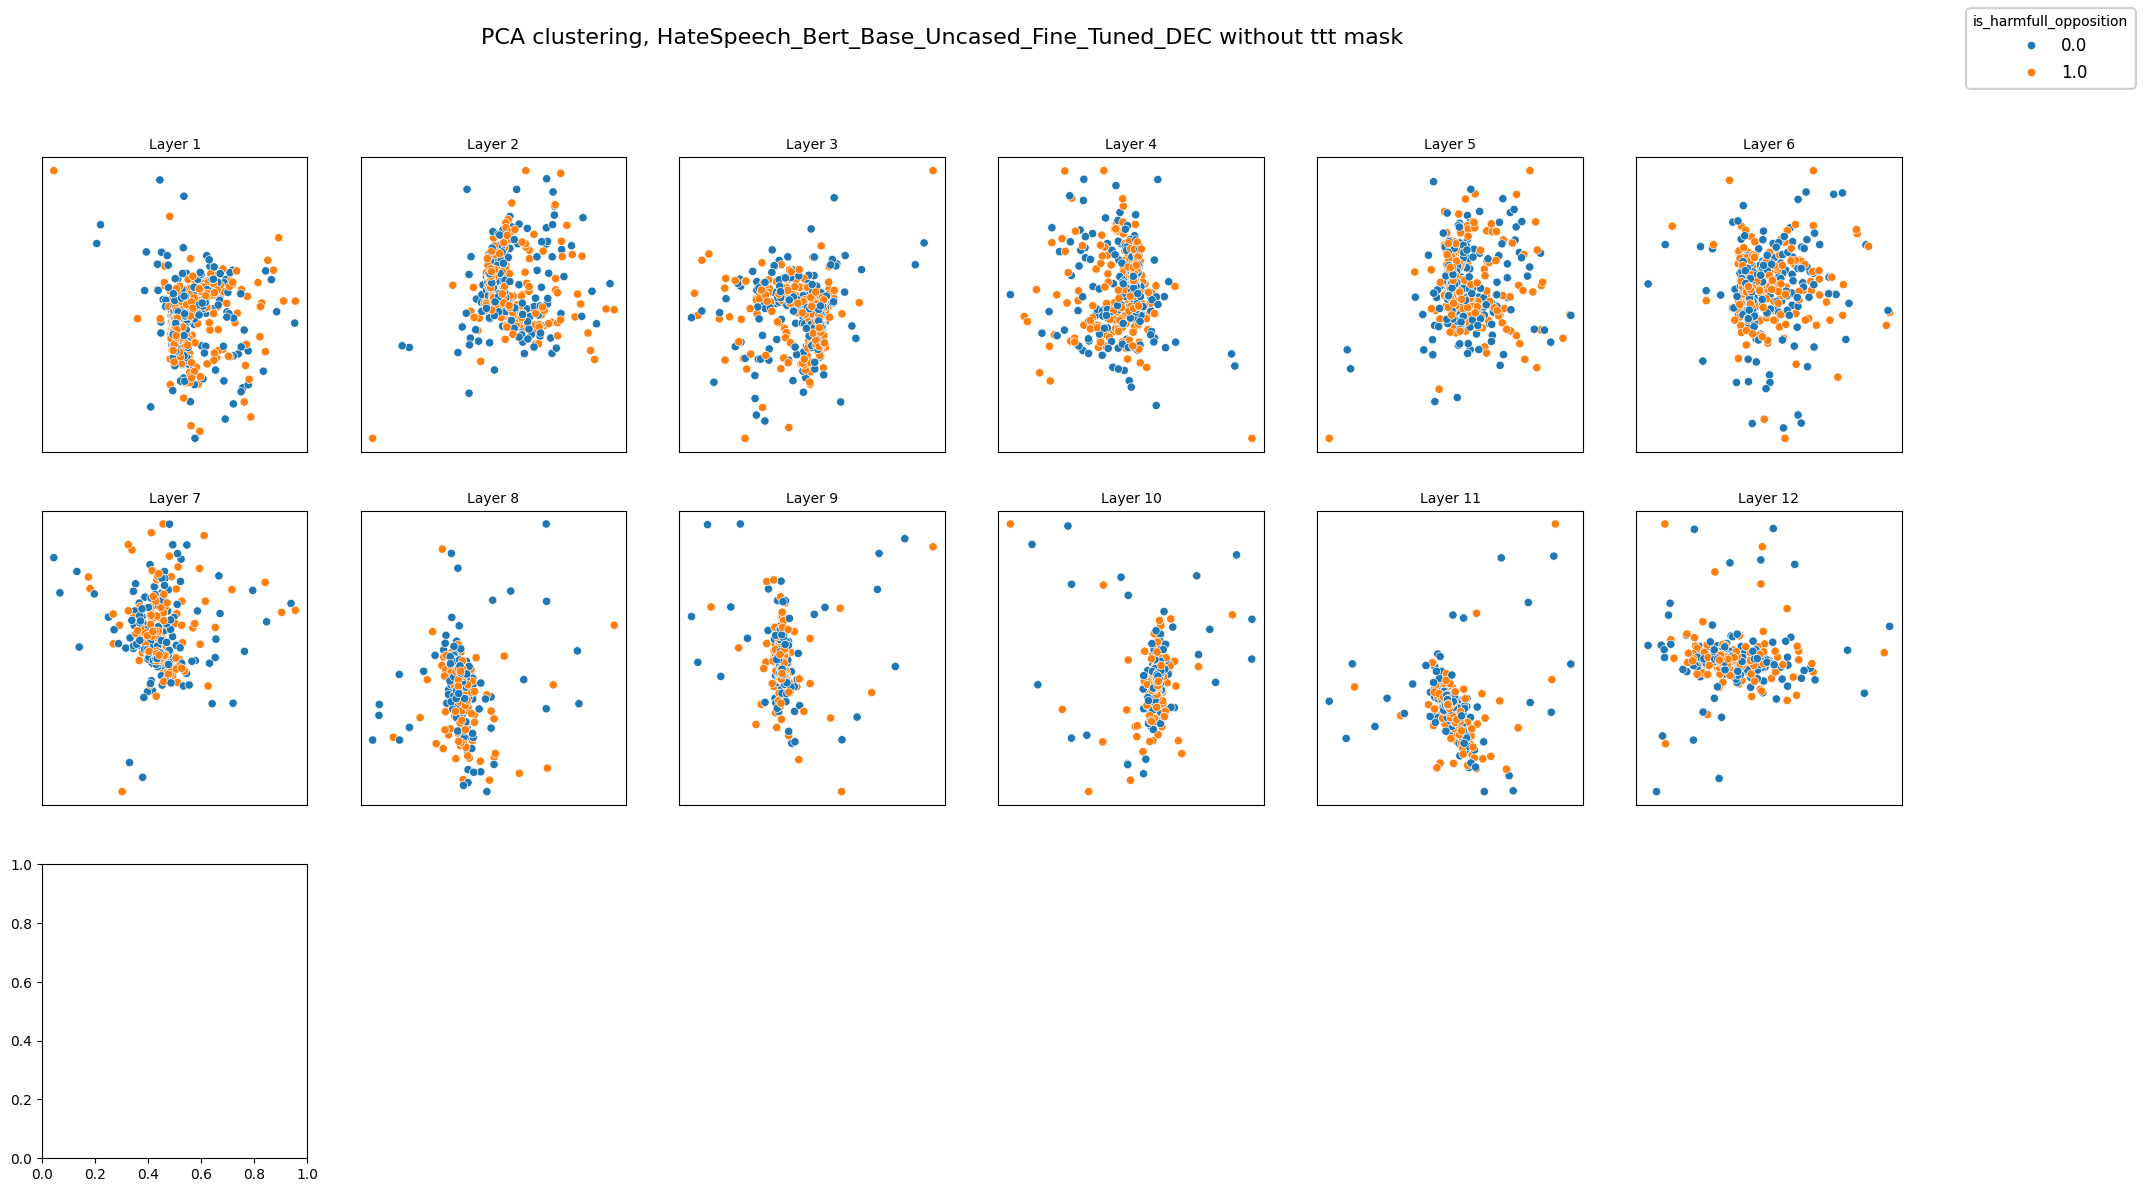

In [138]:
# X_pos = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_pos_small.npy')
# X_neg = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_neg_small.npy')

X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_not_data_yes['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title=f'PCA clustering, {MODEL_NAME} without ttt mask')

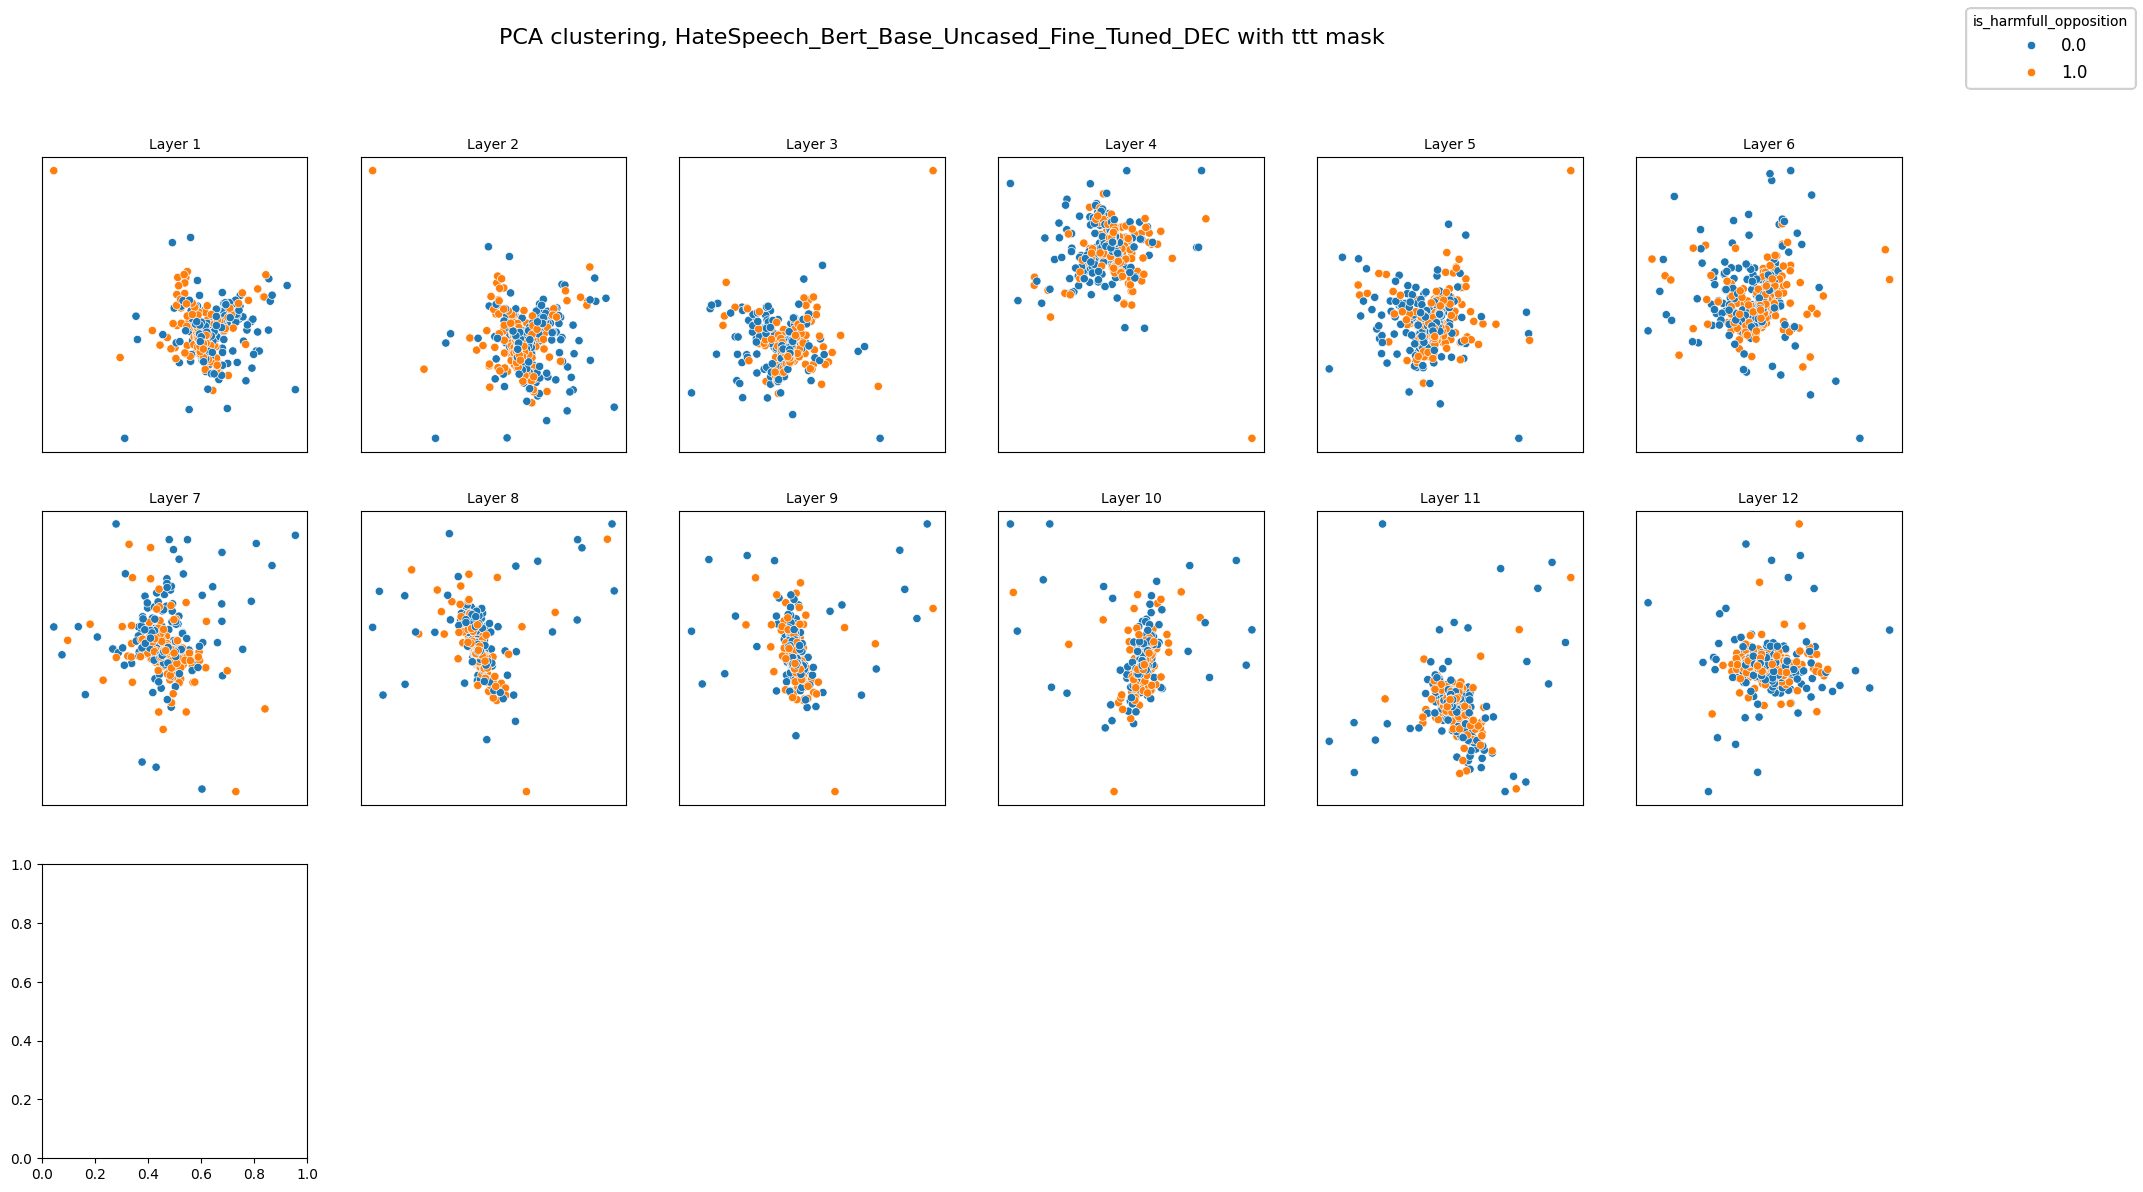

In [141]:
# X_pos = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_pos_small.npy')
# X_neg = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_neg_small.npy')

X_pos_normalized_rnd_check = X_pos_rnd_check.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized_rnd_check= normalize(X_pos_normalized_rnd_check, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized_rnd_check = X_neg_rnd_check.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized_rnd_check = normalize(X_neg_normalized_rnd_check, norm='l2', axis=1).reshape(X_neg.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized_rnd_check,
                           X_neg_normalized_rnd_check,
                           hate_not_data_yes_rnd_check['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title=f'PCA clustering, {MODEL_NAME} with ttt mask')

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.
To train CCS we need dataset organised as follows:

- first $k = \frac{total-samples}{2}$ are harm statements
- next $k$ samples are safe statements
- each pair indexes are $i, i + \frac{total-samples}{2}$

In [132]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_not_data_no['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

Median normalize used
Layer 1/13, CCS accuracy: 0.5769230769230769
Median normalize used
Layer 2/13, CCS accuracy: 0.6410256410256411
Median normalize used
Layer 3/13, CCS accuracy: 0.6025641025641025
Median normalize used
Layer 4/13, CCS accuracy: 0.6025641025641025
Median normalize used
Layer 5/13, CCS accuracy: 0.5897435897435898
Median normalize used
Layer 6/13, CCS accuracy: 0.5897435897435898
Median normalize used
Layer 7/13, CCS accuracy: 0.5641025641025641
Median normalize used
Layer 8/13, CCS accuracy: 0.5641025641025641
Median normalize used
Layer 9/13, CCS accuracy: 0.5641025641025641
Median normalize used
Layer 10/13, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 11/13, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 12/13, CCS accuracy: 0.5256410256410257
Median normalize used
Layer 13/13, CCS accuracy: 0.5128205128205128


In [133]:
# train CCS on normalized states
rnd_ccs = train_ccs_on_hidden_states(X_pos_normalized_rnd_check,
                                        X_neg_normalized_rnd_check,
                                        hate_not_data_no['is_harmfull_opposition'],
                                        train_idx,
                                        test_idx,
                                        normalizing='median')

Median normalize used
Layer 1/13, CCS accuracy: 0.5769230769230769
Median normalize used
Layer 2/13, CCS accuracy: 0.6666666666666666
Median normalize used
Layer 3/13, CCS accuracy: 0.6410256410256411
Median normalize used
Layer 4/13, CCS accuracy: 0.6538461538461539
Median normalize used
Layer 5/13, CCS accuracy: 0.6153846153846154
Median normalize used
Layer 6/13, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 7/13, CCS accuracy: 0.5256410256410257
Median normalize used
Layer 8/13, CCS accuracy: 0.5384615384615384
Median normalize used
Layer 9/13, CCS accuracy: 0.5769230769230769
Median normalize used
Layer 10/13, CCS accuracy: 0.5256410256410257
Median normalize used
Layer 11/13, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 12/13, CCS accuracy: 0.5641025641025641
Median normalize used
Layer 13/13, CCS accuracy: 0.5512820512820513


In [134]:
with open(f'ccs_{MODEL_NAME}_without_ttt_check.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)

with open(f'ccs_{MODEL_NAME}_not_with_ttt_check.pkl', 'wb') as f:
    pickle.dump(rnd_ccs, f)

After that, we train the CCS on the selected layer to obtain the probe and its weights.

In [122]:
from ccs import CCS
import random

LAYER_IDX = 4

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_not_data_no['is_harmfull_opposition'][train_idx]
y_test  = hate_not_data_no['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# # Train CCS without labels first NEG, after POS!
# ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
# ccs.repeated_train()

# # Evaluate
# ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
# print("CCS accuracy: {}".format(ccs_acc))

In [123]:
train_idx[y_train==1], train_idx[y_train==0]

(array([213, 147,  59, 379, 411, 127, 139, 449, 413, 269, 247, 473, 491,
        303, 131, 159, 209, 479, 137, 325, 297, 243, 195, 105, 305, 385,
        351, 425, 347, 161, 201, 471,  63, 403, 293, 275,  85,  31, 501,
        467, 327, 405, 333, 173, 199, 439, 407, 229, 285, 361, 329, 215,
         71,  29, 291, 141,  61, 227, 109, 377, 399,  69, 455, 259, 391,
        465, 235, 203, 205, 321, 311, 287, 345, 381, 323,   5,  95, 313,
         43,   9, 283, 187, 183, 191,   7, 233,  83,  49, 339, 483, 119,
        261,  65, 263, 495, 129,  81, 143, 349,  17, 461, 397, 151, 167,
        169,  57, 115, 157, 509, 267,  87, 153, 315, 133,  89, 103, 149,
          1, 113, 309, 427, 211, 445, 373, 485,  27, 117, 145, 163, 451,
        253, 193,  41,  25, 219, 463, 177,  37,  73, 307, 331, 389, 135,
        503, 353, 165, 123, 273, 125, 181, 395, 341, 475, 513, 487, 239,
         47, 357, 499,  39,  19,  75, 271, 121, 393, 299,  93, 241, 481,
         79, 217, 497, 221, 369, 421, 507, 111, 375

I DON'T UNDERSTAND WHY THE ACCURACY IS DIFFERENT AND I DON'T SEE THE BUG AT ALL

# **6. Steering**

In [27]:
from steering import plot_steering_power, plot_boundary
from steering import PatchHook, PatchHookTOP

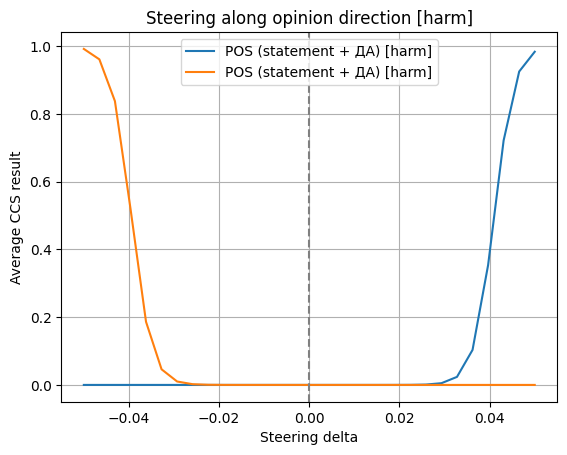

In [28]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[:257], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[:257], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [harm]", "NEG (statement + НЕТ) [harm]"], 
                    title="Steering along opinion direction [harm]")

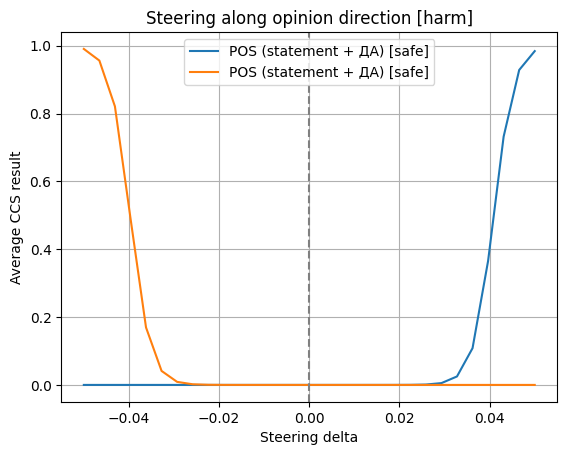

In [29]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[257:], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[257:], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [safe]", "NEG (statement + НЕТ) [safe]"], 
                    title="Steering along opinion direction [harm]")

Manual calibration

In [30]:
idx = 1  # first sample
h_orig = torch.tensor(X_pos_normalized_data.loc[idx], dtype=torch.float32, device=ccs.device)

# ensure weights is numpy array and normalized
weights, bias = ccs.get_weights()

direction = weights / (np.linalg.norm(weights) + 1e-6)
h_steered =h_orig + 0.025*direction

p_orig = ccs.best_probe(h_orig.unsqueeze(0)).item()
p_steered = ccs.best_probe(h_steered.unsqueeze(0)).item()

print(f"Original: {p_orig:.4f}, Steered: {p_steered:.4f}")

Original: 0.0001, Steered: 0.8064


/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_13488/2472194489.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h_steered =h_orig + 0.025*direction


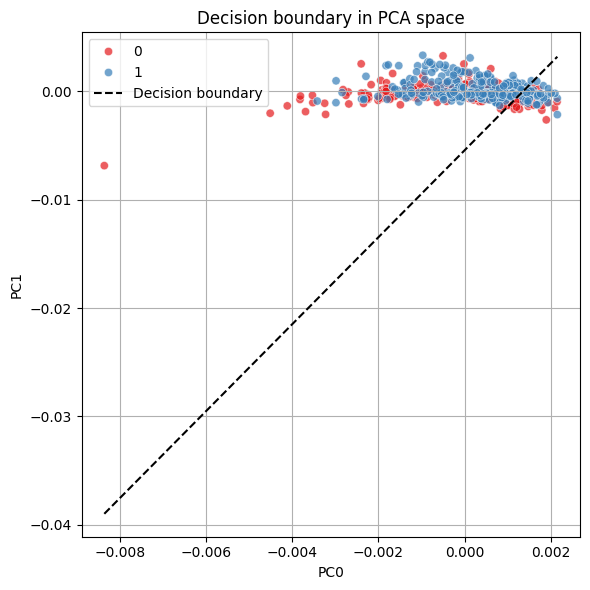

In [31]:
plot_boundary(X_pos_normalized_data, X_neg_normalized_data,  hate_data['is_harmfull_opposition'], ccs, 3, [0, 1])

# 6.1. Steering

Very important: `alpha_neg = -alpha_pos`

In [32]:
direction = torch.tensor(
    ccs.get_weights()[0] / np.linalg.norm(ccs.get_weights()[0]),
    dtype=torch.float32,
    device="cuda" if torch.cuda.is_available() else "cpu"  # 
)

alpha = 0.049
token_idx=0
token_idx_list = [0, 10, 11, 9]

LAYER_IDX = 4

true = hate_data['is_harmfull_opposition'] 
texts = hate_data['statement']
text_yes = texts + " Yes."

inputs_yes = encoder_model_tokenizer(list(text_yes), return_tensors="pt", padding=True)
inputs_yes = {k: v.to(direction.device) for k, v in inputs_yes.items()}

true_tensor = torch.tensor(true.values, dtype=torch.long, device=direction.device)

# Создаём и настраиваем hook_obj
hook_obj = PatchHook(token_idx=token_idx, # which token to adjust
                     direction=direction,  # CCS vector weights (normalize before)
                     character=true_tensor, # y tensor
                       alpha=alpha) #steering coef

# hook_obj = PatchHookTOP(token_idx_list=token_idx_list, # which token to adjust
#                      direction=direction,  # CCS vector weights (normalize before)
#                      character=true_tensor, # y tensor
#                        alpha=alpha) #steering coef


print(f"[MAIN] hook_obj id: {id(hook_obj)}")
print(f"[MAIN] character shape: {hook_obj.character.shape}")

# Hook to specific layer 
#h = encoder_model.deberta.encoder.layer[LAYER_IDX].output.register_forward_hook(hook_obj)

h = encoder_model.deberta.encoder.layer[LAYER_IDX].attention.self.value_proj.register_forward_hook(hook_obj)
# Прогон
with torch.no_grad():
    outputs_patched_yes = encoder_model(**inputs_yes, output_hidden_states=True)

h.remove()

[MAIN] hook_obj id: 14060933616
[MAIN] character shape: torch.Size([514])
Alpha param: 0.049
Patched token 0


In [33]:
# Removing hooks   

def remove_all_forward_hooks(model):
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks.clear()
            remove_all_forward_hooks(child)
    
def remove_all_backward_hooks(model):
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_backward_hooks"):
                child._backward_hooks.clear()
            remove_all_backward_hooks(child)


In [34]:
remove_all_forward_hooks(encoder_model)
encoder_model.deberta.encoder.layer[LAYER_IDX]._forward_hooks.clear()

Negative texts with `-1*alpha`

In [35]:
# Negative texts
text_no = texts + " No."
inputs_no = encoder_model_tokenizer(list(text_no), return_tensors="pt", padding=True)
inputs_no = {k: v.to(direction.device) for k, v in inputs_no.items()}

# Hook
hook_obj2 = PatchHook(token_idx=token_idx, 
                      direction=direction, 
                      character=true_tensor, alpha=-1*alpha)

# hook_obj2 = PatchHookTOP(token_idx_list=token_idx_list, # which token to adjust
#                      direction=direction,  # CCS vector weights (normalize before)
#                      character=true_tensor, # y tensor
#                        alpha=-1*alpha) #steering coef

#h = encoder_model.deberta.encoder.layer[LAYER_IDX].output.register_forward_hook(hook_obj2)
h = encoder_model.deberta.encoder.layer[LAYER_IDX].attention.self.value_proj.register_forward_hook(hook_obj2)
# Run
with torch.no_grad():
    outputs_patched_no = encoder_model(**inputs_no, output_hidden_states=True)

Alpha param: -0.049
Patched token 0


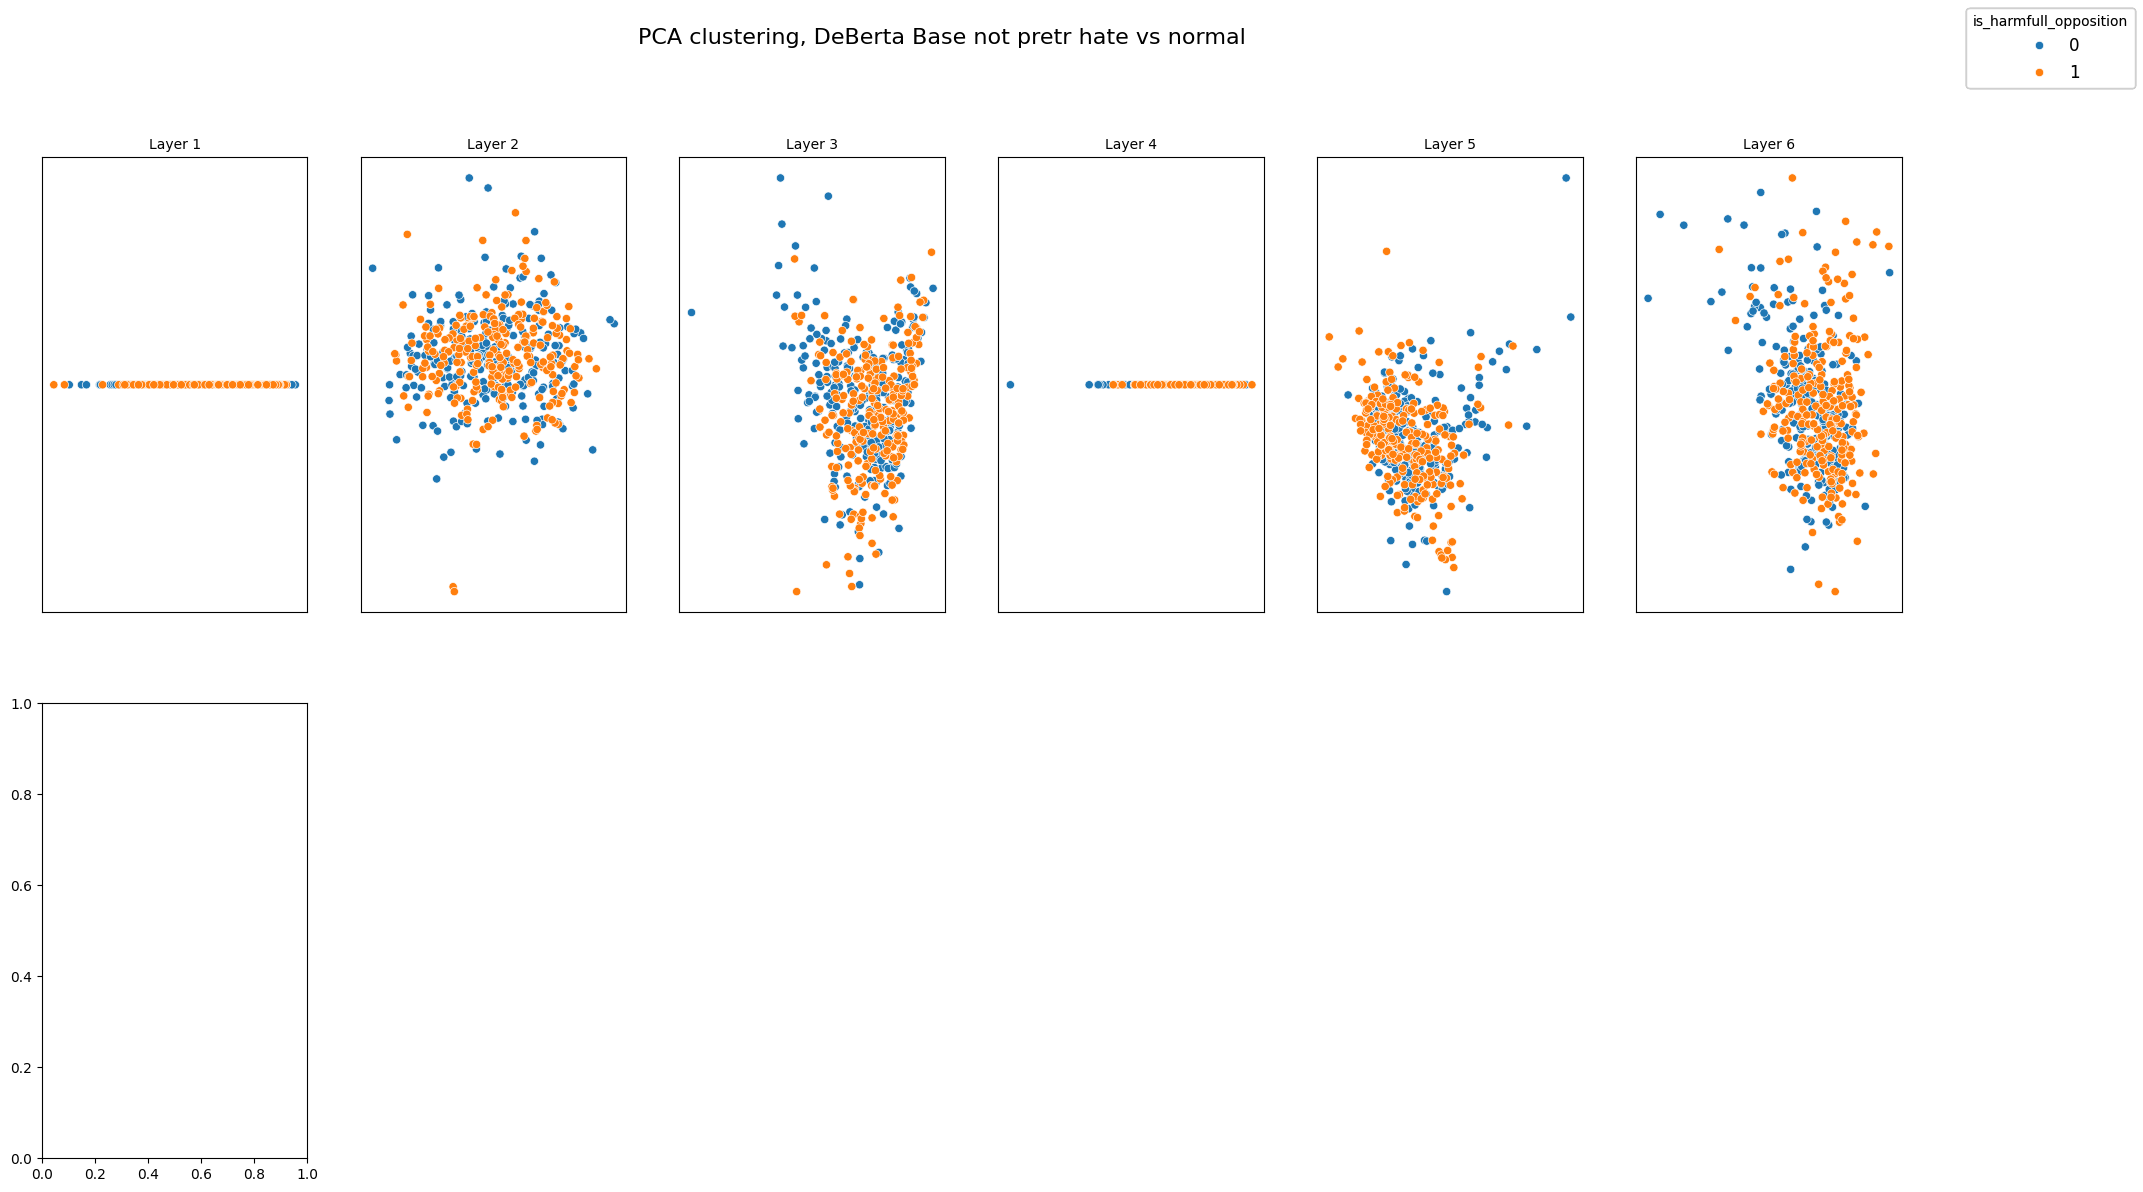

In [39]:
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 2], mode='pca-sparse',
                           plot_title='PCA clustering, DeBerta Base not pretr hate vs normal')

# **7. PCA results and steered probe**

In [36]:
X_pos_st = np.array(outputs_patched_yes.hidden_states)[:, :, 0, :].transpose(1, 0, 2)
X_neg_st = np.array(outputs_patched_no.hidden_states)[:, :, 0, :].transpose(1, 0, 2)

In [37]:
X_pos_st_norm = normalize(X_pos_st[:, LAYER_IDX, :], norm='l2', axis=1)
X_neg_st_norm = normalize(X_neg_st[:, LAYER_IDX, :], norm='l2', axis=1)

classes_st, probas_st = ccs.predict(X_pos_st_norm, X_neg_st_norm)
classes_or, probas_or = ccs.predict(X_neg_normalized[:, LAYER_IDX, :], X_pos_normalized[:, LAYER_IDX, :])

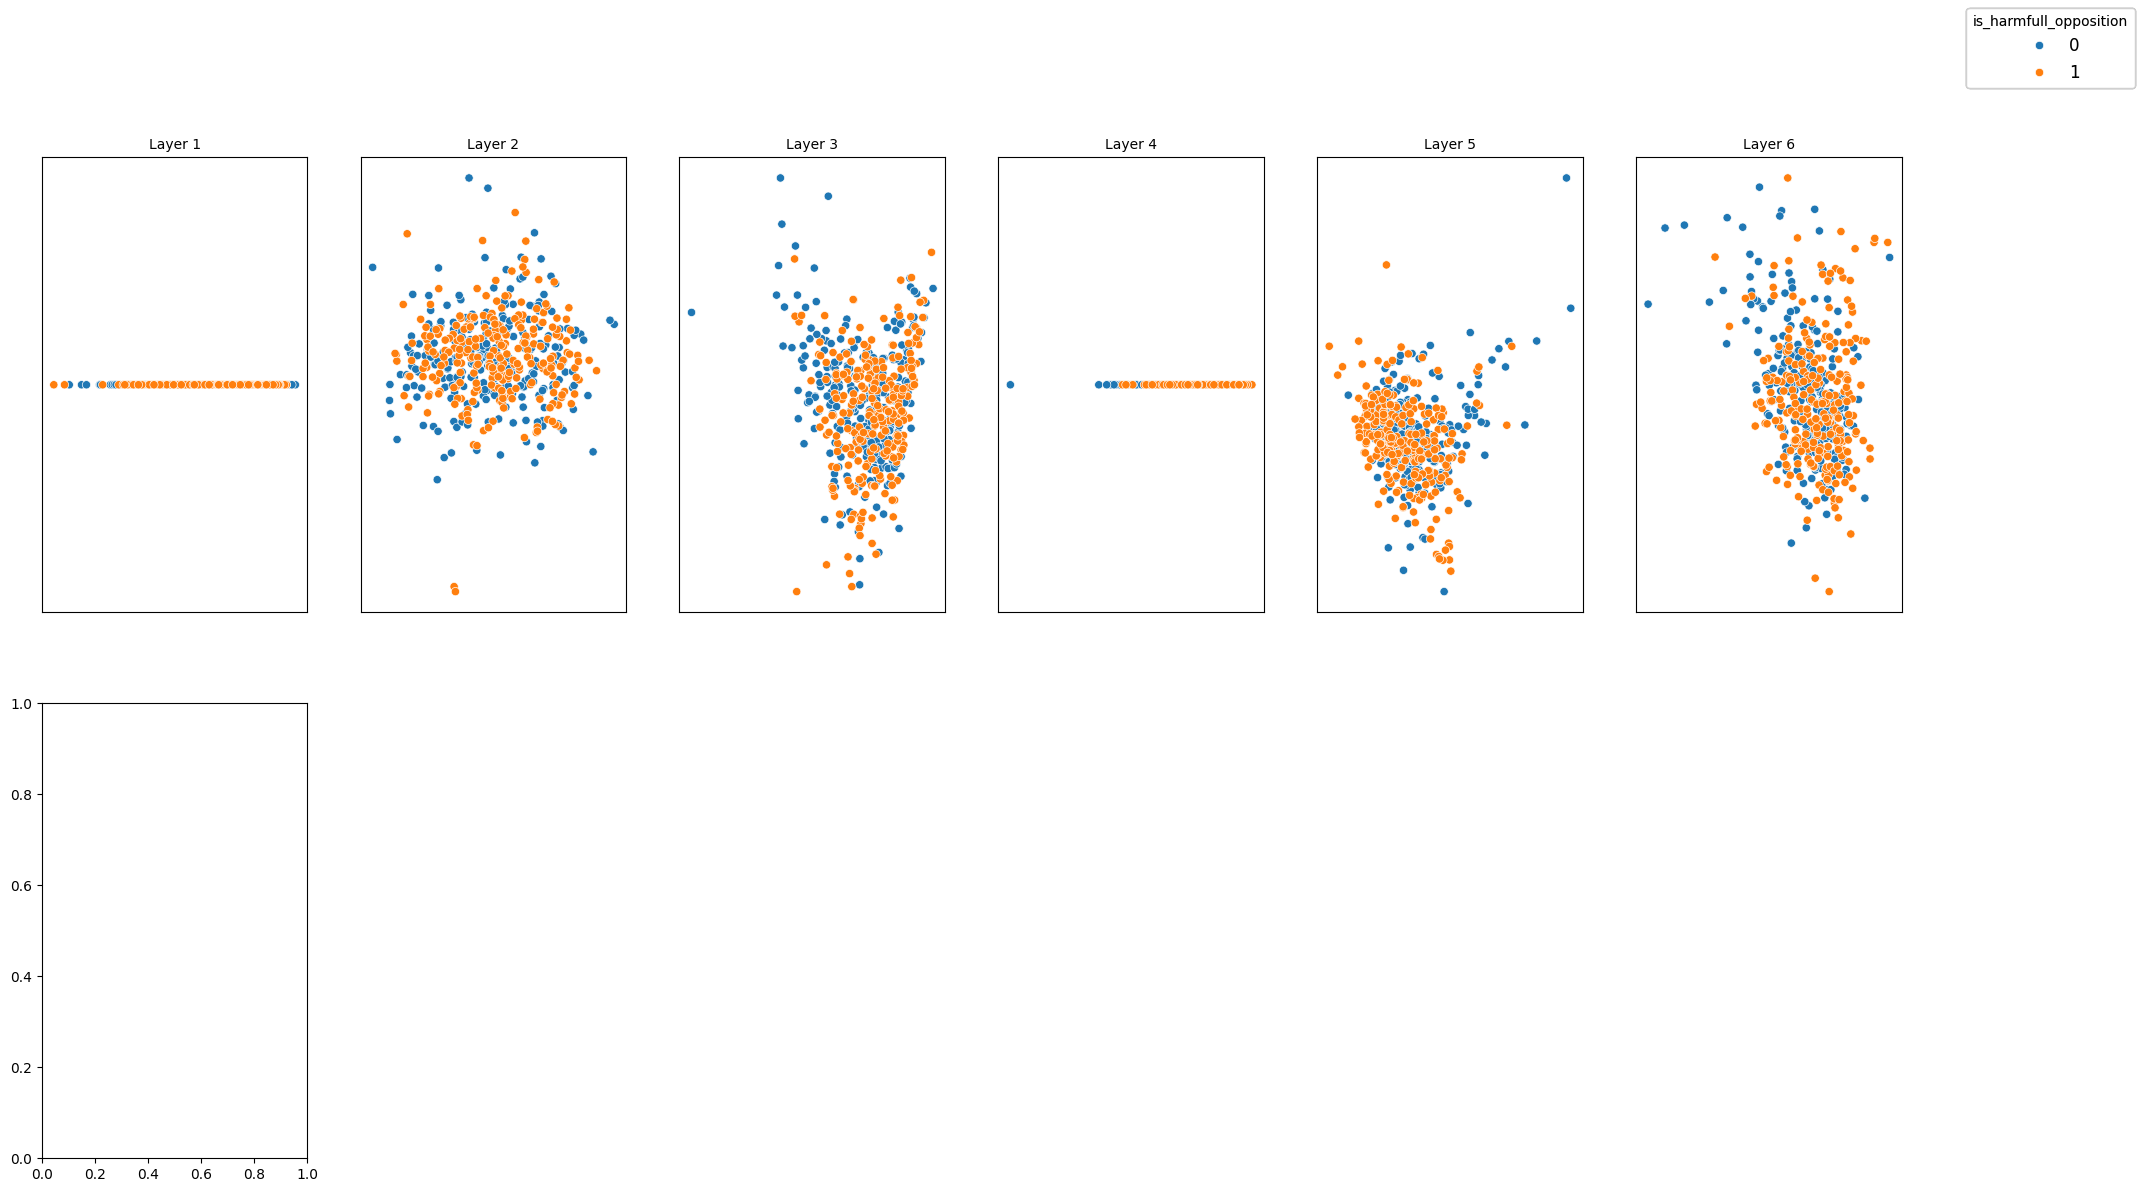

In [40]:
X_pos_st_normalized = X_pos_st.reshape(-1, X_pos_st.shape[-1])         # (512*25, 768)
X_pos_st_normalized = normalize(X_pos_st_normalized, norm='l2', axis=1).reshape(X_pos_st.shape)

X_neg_st_normalized = X_neg_st.reshape(-1, X_neg_st.shape[-1])         # (512*25, 768)
X_neg_st_normalized = normalize(X_neg_st_normalized, norm='l2', axis=1).reshape(X_neg_st.shape)

# Components 1, 3

plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[0, 2],
                           mode='pca-sparse',)

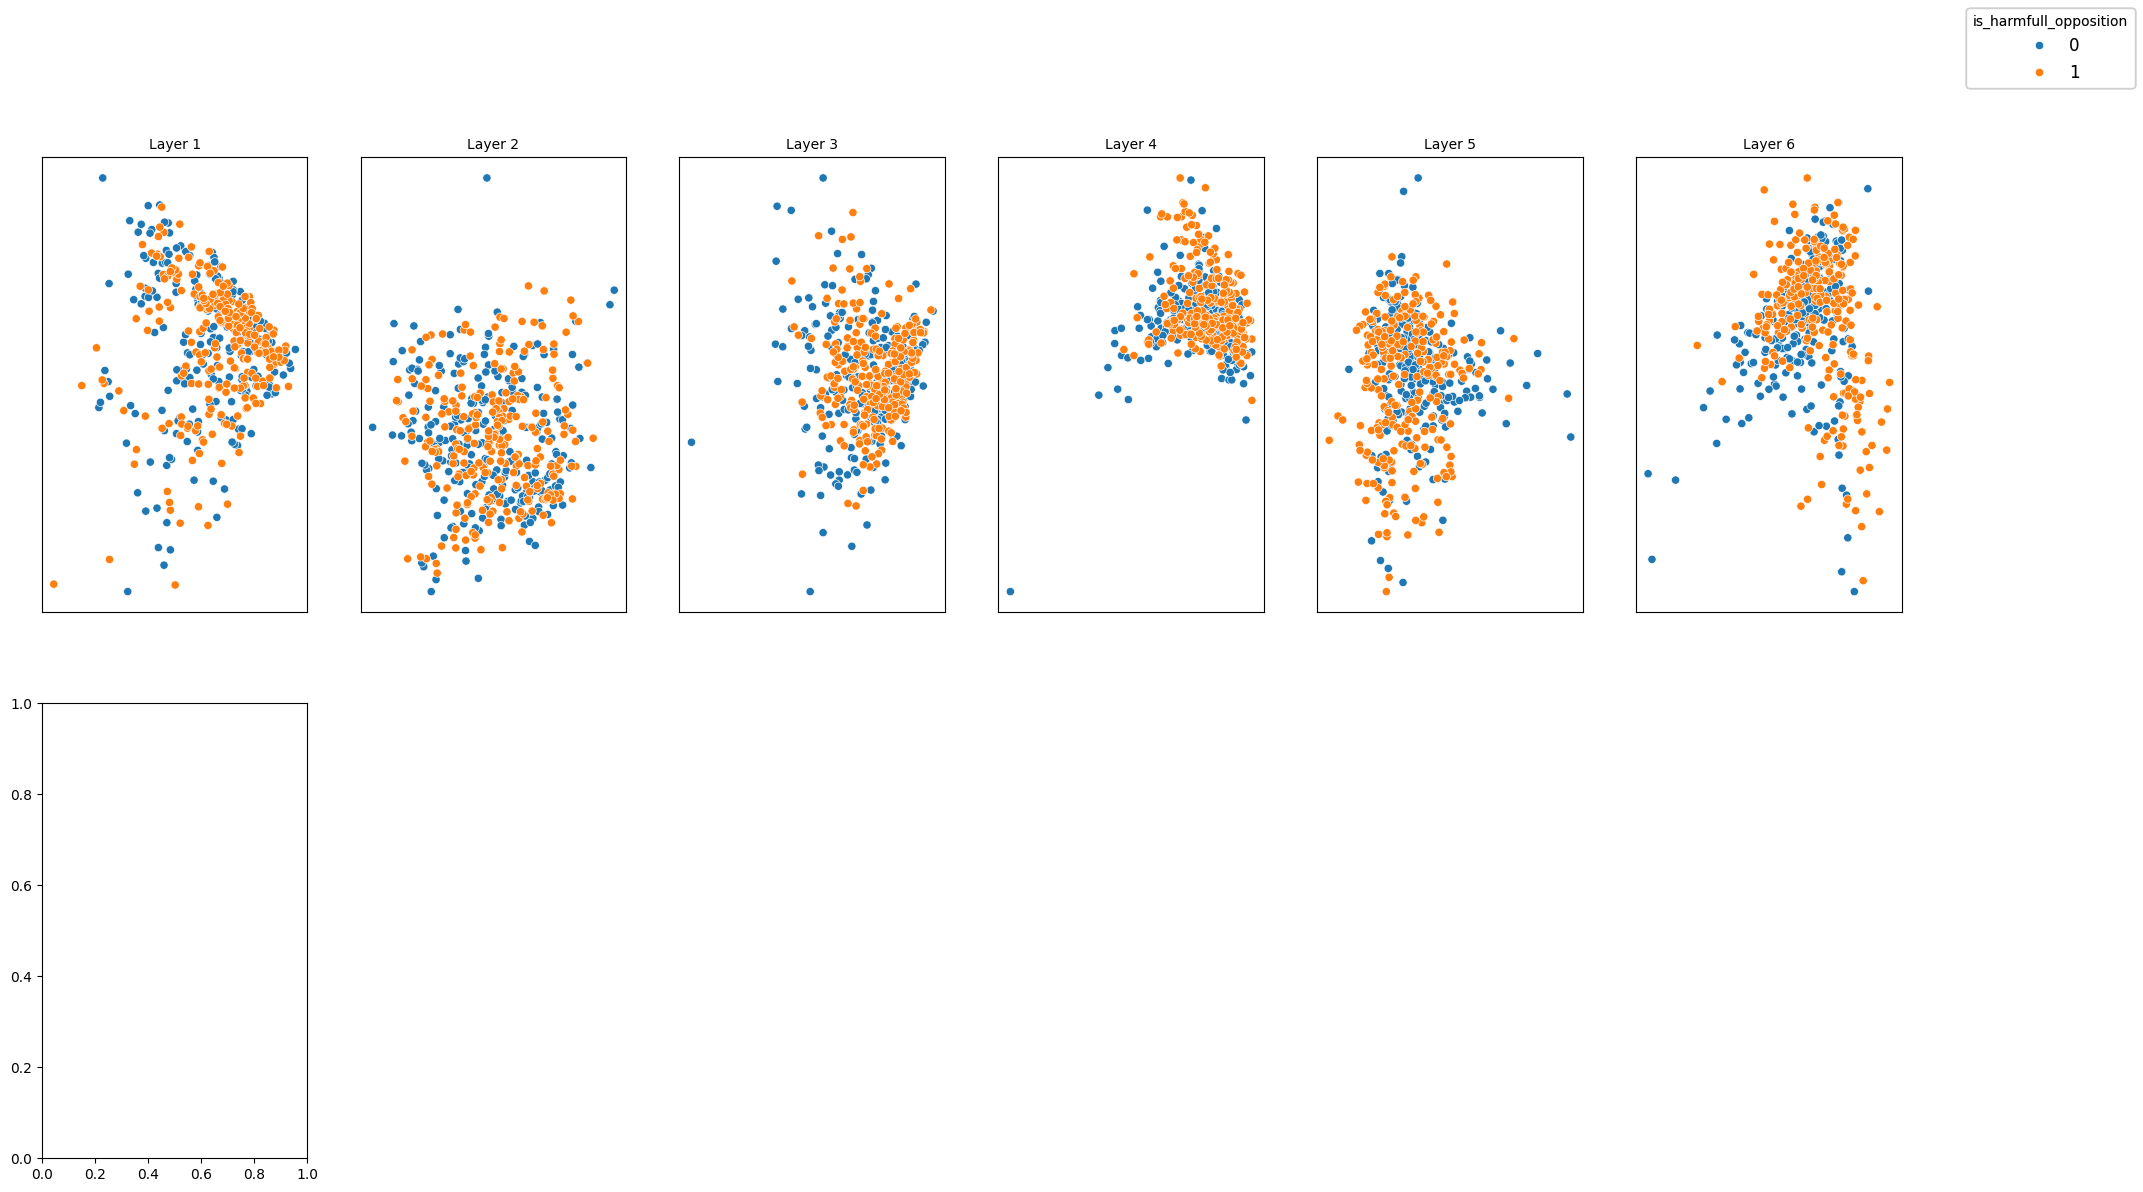

In [84]:
# Components 1, 0
plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[0, 1])

In [70]:
steered_ccs = train_ccs_on_hidden_states(X_pos_st_normalized,
                                        X_neg_st_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

Median normalize used
Layer 1/7, CCS accuracy: 0.5384615384615384
Median normalize used
Layer 2/7, CCS accuracy: 0.5256410256410257
Median normalize used
Layer 3/7, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 4/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 5/7, CCS accuracy: 0.5641025641025641
Median normalize used
Layer 6/7, CCS accuracy: 1.0
Median normalize used
Layer 7/7, CCS accuracy: 1.0


## **7. Plot results tables.**

In [26]:
from format_results import get_results_table

In [27]:
orig_ccs_data = get_results_table(orig_ccs)
st_ccs_data = get_results_table(steered_ccs)

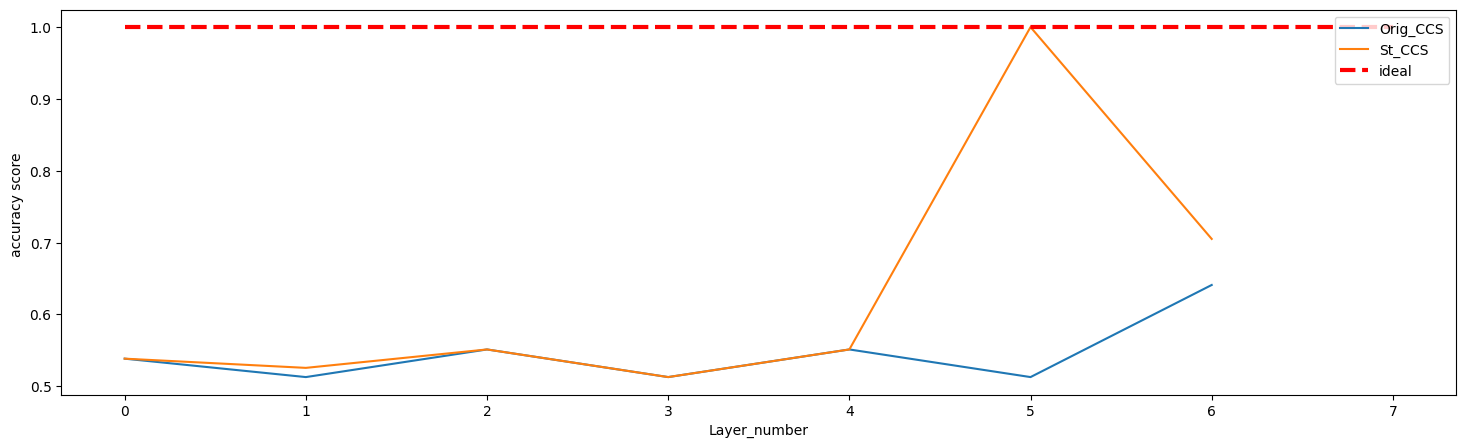

In [28]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['accuracy'], label='Orig_CCS')
plt.plot(st_ccs_data['accuracy'], label='St_CCS')

plt.hlines(1, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('accuracy score ')
plt.legend(loc='upper right');

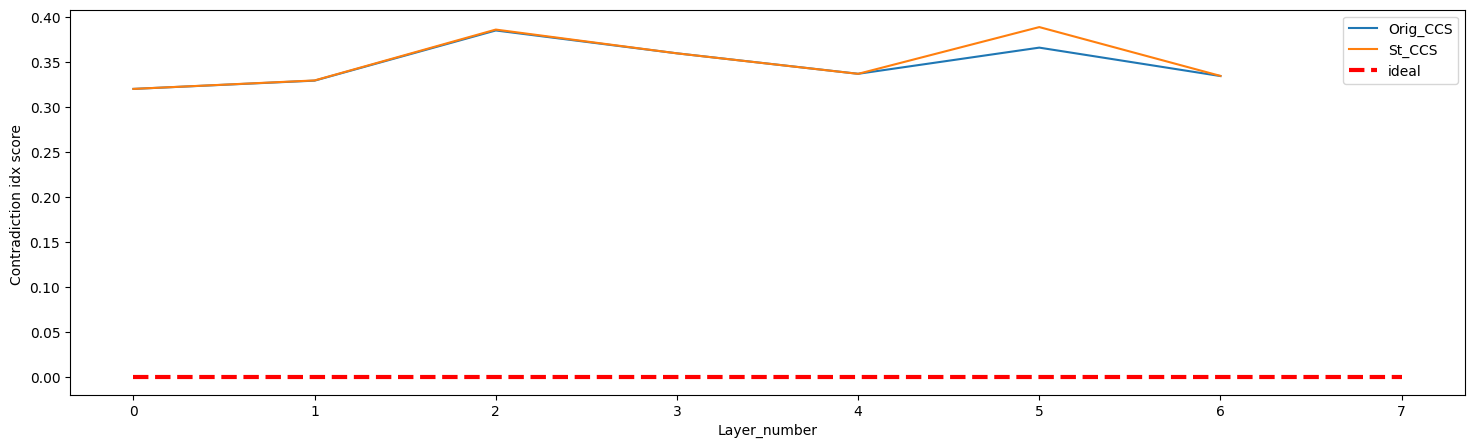

In [29]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['contradiction_idx_↓'], label='Orig_CCS')
plt.plot(st_ccs_data['contradiction_idx_↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Contradiction idx score ')
plt.legend(loc='upper right');

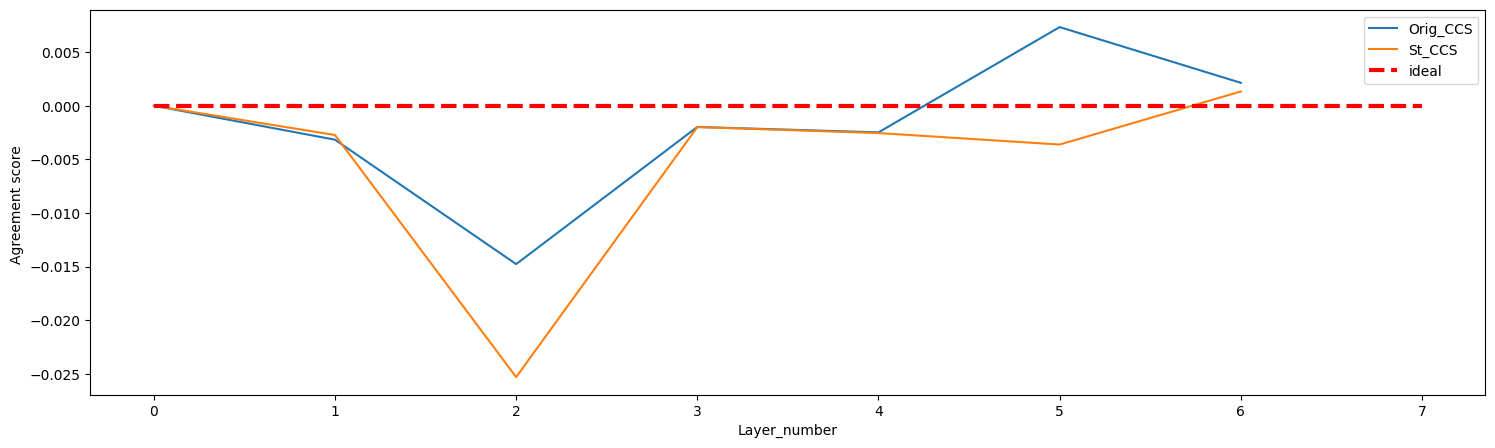

In [30]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['agreement_score_↓'], label='Orig_CCS')
plt.plot(st_ccs_data['agreement_score_↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');

In [25]:
import torch
from transformers import AutoModel, AutoTokenizer


# === Функция: токеновый attribution
def compute_token_attributions(text, model, tokenizer, theta, bias, layer_idx):
    inputs = tokenizer(text, return_tensors="pt", return_attention_mask=True, padding=True, truncation=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Включаем градиенты по embedding
    model.deberta.embeddings.word_embeddings.weight.requires_grad = True

    # Получим embeddings (для backward)
    embeddings = model.deberta.embeddings(input_ids)
    embeddings.retain_grad()

    # Прогон модели с включенным hidden_states
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask, output_hidden_states=True)
    h_cls = outputs.hidden_states[layer_idx][0, 0, :]  # [hidden_dim]

    # Вычисляем логит CCS
    logit = torch.dot(h_cls, theta) + bias

    # Градиенты по входу
    model.zero_grad()
    logit.backward()

    # Градиенты embeddings: [batch, seq_len, hidden_dim]
    grads = embeddings.grad[0]  # [seq_len, hidden_dim]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Attribution по L2 или dot-product с theta
    attributions = (grads * embeddings[0]).sum(dim=1).detach()  # dot-product IG style
    attributions = attributions / attributions.norm(p=1)  # нормировка

    return list(zip(tokens, attributions.tolist())), embeddings.grad


In [26]:
text = hate_yes_data.iloc[:, 1].values.tolist()

inputs = encoder_model_tokenizer(text, return_tensors="pt", return_attention_mask=True, padding=True, truncation=True)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

    # Включаем градиенты по embedding
encoder_model.deberta.embeddings.word_embeddings.weight.requires_grad = True

    # Получим embeddings (для backward)
embeddings = encoder_model.deberta.embeddings(input_ids)

embeddings.retain_grad()

    # Прогон модели с включенным hidden_states
outputs = encoder_model(inputs_embeds=embeddings, attention_mask=attention_mask, output_hidden_states=True)
h_cls = outputs.hidden_states[LAYER_IDX][:, 0, :]  # [hidden_dim]

    # Вычисляем логит CCS
logit = h_cls @ direction + bias


    # Градиенты по входу
encoder_model.zero_grad()
logit.sum().backward()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [29]:
grads = embeddings.grad # [batch, seq_len, hidden_dim]
print(grads.shape)

torch.Size([514, 36, 768])


In [30]:
tokens = [encoder_model_tokenizer.convert_ids_to_tokens(input_ids[i]) for i in range(input_ids.shape[0])]

In [31]:
# Attribution по L2 или dot-product с theta
attributions_pos = (grads * embeddings).sum(dim=-1).detach()  # dot-product IG style
attributions_pos = attributions_pos / attributions_pos.norm(p=1)  # нормировка

In [ ]:
torch.topk(torch.abs(attributions_pos).sum(0), k=5) # top positive tokens 0, 10, 11, 9

torch.return_types.topk(
values=tensor([0.1625, 0.0649, 0.0595, 0.0578, 0.0567]),
indices=tensor([ 0, 10, 11,  9, 12]))

In [27]:
text = hate_no_data.iloc[:, 1].values.tolist()

inputs = encoder_model_tokenizer(text, return_tensors="pt", return_attention_mask=True, padding=True, truncation=True)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

    # Включаем градиенты по embedding
encoder_model.deberta.embeddings.word_embeddings.weight.requires_grad = True

    # Получим embeddings (для backward)
embeddings = encoder_model.deberta.embeddings(input_ids)

embeddings.retain_grad()

    # Прогон модели с включенным hidden_states
outputs = encoder_model(inputs_embeds=embeddings, attention_mask=attention_mask, output_hidden_states=True)
h_cls = outputs.hidden_states[LAYER_IDX][:, 0, :]  # [hidden_dim]

    # Вычисляем логит CCS
logit = h_cls @ direction + bias


    # Градиенты по входу
encoder_model.zero_grad()
logit.sum().backward()

grads = embeddings.grad # [batch, seq_len, hidden_dim]
print(grads.shape)

tokens = [encoder_model_tokenizer.convert_ids_to_tokens(input_ids[i]) for i in range(input_ids.shape[0])]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([514, 36, 768])


In [ ]:
# Attribution по L2 или dot-product с theta
attributions_no = (grads * embeddings).sum(dim=-1).detach()  # dot-product IG style
attributions_no = attributions_no / attributions_no.norm(p=1)  # нормировка

torch.topk(torch.abs(attributions_no).sum(0), k=5) # top negative tokens 0, 10, 9, 11

torch.return_types.topk(
values=tensor([0.2889, 0.0645, 0.0627, 0.0603, 0.0534]),
indices=tensor([ 0, 10,  9, 11,  8]))

In [ ]:
# logits = h_cls @ direction  # [B]
# grads = torch.autograd.grad(outputs=logits, inputs=direction,
#                             grad_outputs=torch.eye(len(text)),  # или один-hot
#                             retain_graph=True)

In [149]:
text = hate_yes_data.iloc[:3, 1].values.tolist()
attributions, grad = compute_token_attributions(text, 
encoder_model, encoder_model_tokenizer, 
direction, bias, LAYER_IDX)

scores = []
for string in text:
    attributions, grad = compute_token_attributions(string, 
            encoder_model, encoder_model_tokenizer, 
                direction, bias, LAYER_IDX)
    
    for token, score in attributions:
        print(f"{token:15} {score:+.4f}")

[CLS]           -0.3304
▁Homosexual     +0.0105
s               -0.0518
▁want           -0.0009
▁to             -0.0018
▁have           +0.0149
▁sex            +0.0211
▁with           +0.0316
▁as             -0.0316
▁many           +0.0105
▁different      +0.0475
▁men            +0.0149
▁as             -0.0035
▁possible       +0.0035
.               +0.1441
▁Yes            -0.0211
.               -0.1265
[SEP]           -0.1336
[CLS]           +0.0715
▁Violence       +0.0128
▁against        +0.0664
▁women          +0.0032
▁is             -0.1252
▁a              -0.1277
▁migrant        +0.0613
▁problem        -0.0102
.               +0.2810
▁Yes            +0.0409
.               -0.0568
[SEP]           +0.1430
[CLS]           -0.1885
▁Blacks         -0.0969
▁are            -0.0314
▁just           +0.1361
▁degenerate     +0.0052
s               +0.0419
.               +0.2304
▁Yes            +0.0052
.               -0.0759
[SEP]           -0.1885


In [117]:
grad.shape

torch.Size([1, 10, 768])